# Supplementary Information: Holmes *et al.* 2017

# 2. A simple model

In [1]:
%pylab inline

import numpy as np
import pandas as pd
import pystan
import scipy
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

sns.set_context('notebook')

Populating the interactive namespace from numpy and matplotlib


/Users/lpritc/Development/GitHub/Supplementary_Info/SI_Holmes_etal_2016/venv-SI_Holmes_2016/lib/python3.5/site-packages/Cython/Distutils/old_build_ext.py:30: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "


## Building the model

The simplest model we can construct is to treat each probe in each replicate (under both conditions) as an independent observation, and that the output value is some linear function of the input value, mediated by the experiment. This is a completely pooled model.

We construct the following model of the experiment:

$$y_i = \alpha + \beta x_i + \epsilon_i$$

* $y_i$: measured log(intensity) output on the array for probe $i$ (specific to each replicate)
* $x_i$: measured log(intensity) input on the array for probe $i$ (specific to each replicate)
* $\alpha$: a representative log(intensity) level for the input array
* $\beta$: the effect of the experiment on the measured log(intensity) for probe $i$
* $\epsilon_i$: error in the model prediction for probe $i$

### Stan model construction and fit

We need to define `data`, `parameters` and our `model` for `Stan`.

In the `data` block, we have:

* `N`: `int`, the number of probes (total data points, 
* `x`: `vector[N]`, the input log(intensity) values
* `y`: `vector[N]`, the output log(intensity) values

In the `parameter` block, we have:

* `a`: `real`, representative input log(intensity)
* `b`: `real`, effect on log(intensity) of passing through the experiment
* `sigma`: `real<lower=0>`, the error in the prediction

We define the model as $y \sim N(\alpha + \beta x, \sigma^2)$.

In [2]:
# define simple stan model
simple_model = """
data {
  int<lower=0> N;
  vector[N] x;
  vector[N] y;
}
parameters {
  real a;
  real b;
  real<lower=0> sigma;
}
model {
  y ~ normal(a + b * x, sigma);
}
"""

We map Python variables to the `stan` model, but to do this we need to load our cleaned, normalised data:

In [3]:
# load clean, normalised data
data = pd.read_csv("output/normalised_array_data.tab", sep="\t")

In [4]:
# relate python variables to stan variables
simple_data_dict = {'N': len(data),
                    'x': data['input'],
                    'y': data['output']}

In [5]:
# run stan fit
simple_fit = pystan.stan(model_code=simple_model,
                         data=simple_data_dict,
                         iter=1000, chains=2)

## Inspecting the fit

We can inspect the fitted parameter estimates straightforwardly:

In [6]:
def plot_fit_params(fit, params):
    nparams = len(params)
    fig, axes = plt.subplots(nparams, 2,
                             figsize=(10, nparams * 2.5))
    fig.subplots_adjust(hspace=0.3)
    
    for idx, vbl, title in zip(range(nparams), params,
                               params):
        # density plot
        sns.kdeplot(fit[vbl], ax=axes[idx][0])
        axes[idx][0].set_xlim(fit[vbl].min(),
                              fit[vbl].max())
        # scatterplot
        axes[idx][1].plot(fit[vbl], 'o', alpha=0.3)
    
        # labels
        axes[idx][0].set_title(title)
        axes[idx][1].set_title(title)
    axes[nparams-1][0].set_xlabel("value")
    axes[nparams-1][1].set_xlabel("iteration")

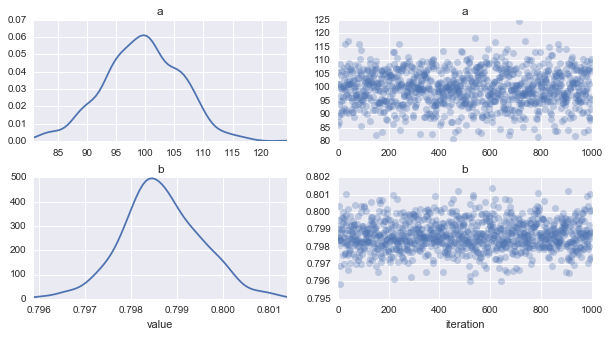

In [7]:
# Plot fitted parameters
plot_fit_params(simple_fit, ['a', 'b'])

This simple model fit gives us mean estimates of $\alpha \approx 99$ and $\beta \approx 0.8$, and the credibility intervals are quite tight around those values - they are almost certainly non-zero:

In [8]:
# mean estimates
a_mean = simple_fit['a'].mean()
b_mean = simple_fit['b'].mean()
print('alpha: {0:.3f}'.format(a_mean),
      'beta: {0:.3f}'.format(b_mean))

alpha: 99.504 beta: 0.799


In [9]:
# 50% intervals
print('alpha 50% CI: {0:.3f}..{1:.3f}'.format(*tuple(np.percentile(simple_fit['a'], [25, 75]))))
print('beta 50% CI: {0:.3f}..{1:.3f}'.format(*tuple(np.percentile(simple_fit['b'], [25, 75]))))

alpha 50% CI: 94.991..104.282
beta 50% CI: 0.798..0.799


But does the model fit the data very well?

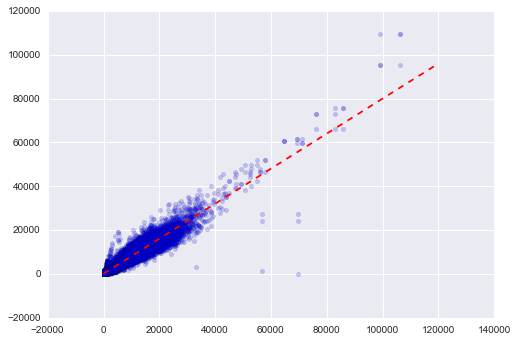

In [10]:
# Plot the fitted model on the data
plt.scatter(data['input'], data['output'], alpha=0.2)
xvals = np.linspace(-1, 120000)
plt.plot(xvals, a_mean + b_mean * xvals, 'r--');

There is certainly a linear relationship betweeen input and output, and the model fit tracks that reasonably well. But there's quite a bit of variance around that fit, and we may be able to capture it with a more complex model. Specifically, with a more complex model, we may be able to infer differences in this relationship between probes, and so identify those that are more strongly influenced by the passage component of the experiment.

Taking this model at face value, the slope $\beta < 1$ implies that there is net loss of material between input and output intensities for each experiment and replicate.